In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import os

import numpy as np
import CNN_Module as cnn_module
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import random
import glob
import CNN_Module as cnn_module
import models
import glue_code
from keras.utils.layer_utils import print_summary
from keras.models import save_model
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

from plotting import visualise_img_in_layer
from plotting import plti

Using TensorFlow backend.


In [2]:
result_acc = []
result_val_acc = []

video_path = '/cropped_video100_140'
sample_gap = 10
epochs=30
stepsperepoch=100

#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)
train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)
train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus


im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

model = models.get_luke_model_140_2((140,100,1))

augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid) #no flipping

training_generator = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train)
prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)

validate_steps = len(im_paths_test)//32

fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
#pickle.dump(fully_train_model, open("/home/ubuntu/data/code/Visualisation/2d100_140nn.p", "wb"))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
100/100 [==============================] - 7s 74ms/step - loss: 0.8482 - acc: 0.5828 - val_loss: 0.6652 - val_acc: 0.5915
Epoch 2/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6473 - acc: 0.6016 - val_loss: 0.6465 - val_acc: 0.7933
Epoch 3/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6200 - acc: 0.6406 - val_loss: 0.6119 - val_acc: 0.7059
Epoch 4/30
100/100 [==============================] - 4s 39ms/step - loss: 0.5905 - acc: 0.6713 - val_loss: 0.5839 - val_acc: 0.7680
Epoch 5/30
100/100 [==============================] - 4s 40ms/step - loss: 0.5631 - acc: 0.6878 - val_loss: 0.5337 - val_acc: 0.7917
Epoch 6/30
100/100 [==============================] - 4s 40ms/step - loss: 0.5704 - acc: 0.6834 - val_loss: 0.

100/100 [==============================] - 4s 40ms/step - loss: 0.4214 - acc: 0.7922 - val_loss: 0.5000 - val_acc: 0.7680


In [2]:
#save_model(fully_train_model,"/home/ubuntu/data/code/visualisation/2d_cipro1")
model = load_model("/home/ubuntu/data/code/visualisation/2d_cipro1")

#model = fully_train_model
print(model.summary())













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 140, 100, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 100, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 50, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 50, 32)        128       
_________________________________________________

In [2]:
# pick image

## resistant image
#test_image_path = ('/home/ubuntu/data/resistant/sample24/cell167/cropped_video100_140/croppedvideo000.tiff')
## susceptible image
test_image_path = ('/home/ubuntu/data/resistant/sample28/cell330/cropped_video100_140/croppedvideo000.tiff')
print(test_image_path)

/home/ubuntu/data/resistant/sample28/cell330/cropped_video100_140/croppedvideo000.tiff


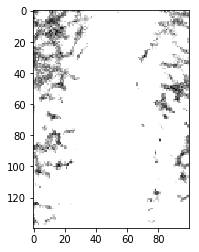

In [3]:
test_image = load_img(test_image_path, color_mode='grayscale')
from PIL import Image
from matplotlib.pyplot import imshow
#imshow(test_image, cmap='veridis')
imshow(test_image, cmap='gist_gray')

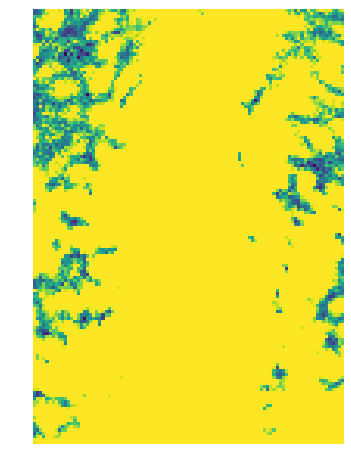

In [4]:
test_image = img_to_array(test_image)
img_to_visualize = np.expand_dims(test_image, axis=0)
plti(np.squeeze(test_image), h=8)

In [5]:
layer = model.get_layer('conv2d_1')
visualise_img_in_layer(model, layer, img_to_visualize)

NameError: name 'model' is not defined